In [2]:
from disease_prediction.data import datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

In [3]:
directory = '../disease_prediction/data/'

## optimal model hyperparameters
n_estimators = 500
max_depth = 20
min_samples_leaf = 5
bootstrap = False

In [4]:
df = ds.load_datasets(subsets=['train', 'validate', 'test'],
                      directory=directory)

df_train = pd.concat([df['train'], df['validate']],
                     axis=0,
                     ignore_index=True)


# Data cleaning, feature engineering.

In [5]:
## removing lesion_peeling, pain_radiate columns
df_train.drop(columns=['lesions_peeling', 'pain_radiate'], inplace=True)


## one hot encoding for all categorical features
categorical_features=df_train.select_dtypes(include='object').columns.tolist()

categorical_features.remove('PATHOLOGY')
categorical_features.remove('pain_somewhere')
categorical_features.remove('lesion_location')

df_train = pd.get_dummies(df_train,
                          columns=categorical_features,
                          dtype=int)


df_train['lesion_location'] = (df_train['lesion_location'] != 'nowhere').astype(int)
df_train['pain_somewhere'] = (df_train['pain_somewhere'] != 'nowhere').astype(int)

# Preliminary random forest classifier

In [6]:
X = df_train.drop(columns=['PATHOLOGY', 'index'])
y = df_train.PATHOLOGY

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  stratify=y,
                                                  test_size=0.2,
                                                  shuffle=True)

In [8]:
rf_prelim = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    bootstrap=bootstrap
)

rf_prelim.fit(X_train, y_train)
pred_prelim = rf_prelim.predict(X_val)
prelim_report = classification_report(y_val, pred_prelim, 
                            digits=4, output_dict=True)
print(prelim_report)

{'Allergic sinusitis': {'precision': 0.8531966643502432, 'recall': 0.8664431898376852, 'f1-score': 0.8597689075630253, 'support': 5668.0}, 'Anaphylaxis': {'precision': 0.965, 'recall': 0.3985702938840349, 'f1-score': 0.5641371557054525, 'support': 6295.0}, 'Chagas': {'precision': 1.0, 'recall': 0.22313253012048193, 'f1-score': 0.36485421591804573, 'support': 2075.0}, 'HIV (initial infection)': {'precision': 0.4014524573551765, 'recall': 0.7232618286931386, 'f1-score': 0.5163182188433343, 'support': 6573.0}, 'Influenza': {'precision': 0.7775255391600454, 'recall': 0.22532894736842105, 'f1-score': 0.3494006630961489, 'support': 6080.0}, 'Localized edema': {'precision': 0.5217787346803577, 'recall': 0.9995241116751269, 'f1-score': 0.6856365614798694, 'support': 6304.0}, 'SLE': {'precision': 1.0, 'recall': 0.2870955745630346, 'f1-score': 0.4461138399306559, 'support': 2689.0}, 'Sarcoidosis': {'precision': 0.578021978021978, 'recall': 0.7030639522928234, 'f1-score': 0.6344405269994433, 'sup

In [9]:
print(classification_report(y_val, pred_prelim, 
                            digits=4, output_dict=False))

                         precision    recall  f1-score   support

     Allergic sinusitis     0.8532    0.8664    0.8598      5668
            Anaphylaxis     0.9650    0.3986    0.5641      6295
                 Chagas     1.0000    0.2231    0.3649      2075
HIV (initial infection)     0.4015    0.7233    0.5163      6573
              Influenza     0.7775    0.2253    0.3494      6080
        Localized edema     0.5218    0.9995    0.6856      6304
                    SLE     1.0000    0.2871    0.4461      2689
            Sarcoidosis     0.5780    0.7031    0.6344      4863
           Tuberculosis     0.5689    0.4693    0.5143      3650
         Whooping cough     1.0000    1.0000    1.0000      1323

               accuracy                         0.6049     45520
              macro avg     0.7666    0.5896    0.5935     45520
           weighted avg     0.7149    0.6049    0.5823     45520



# Fine tuning features to use for final model

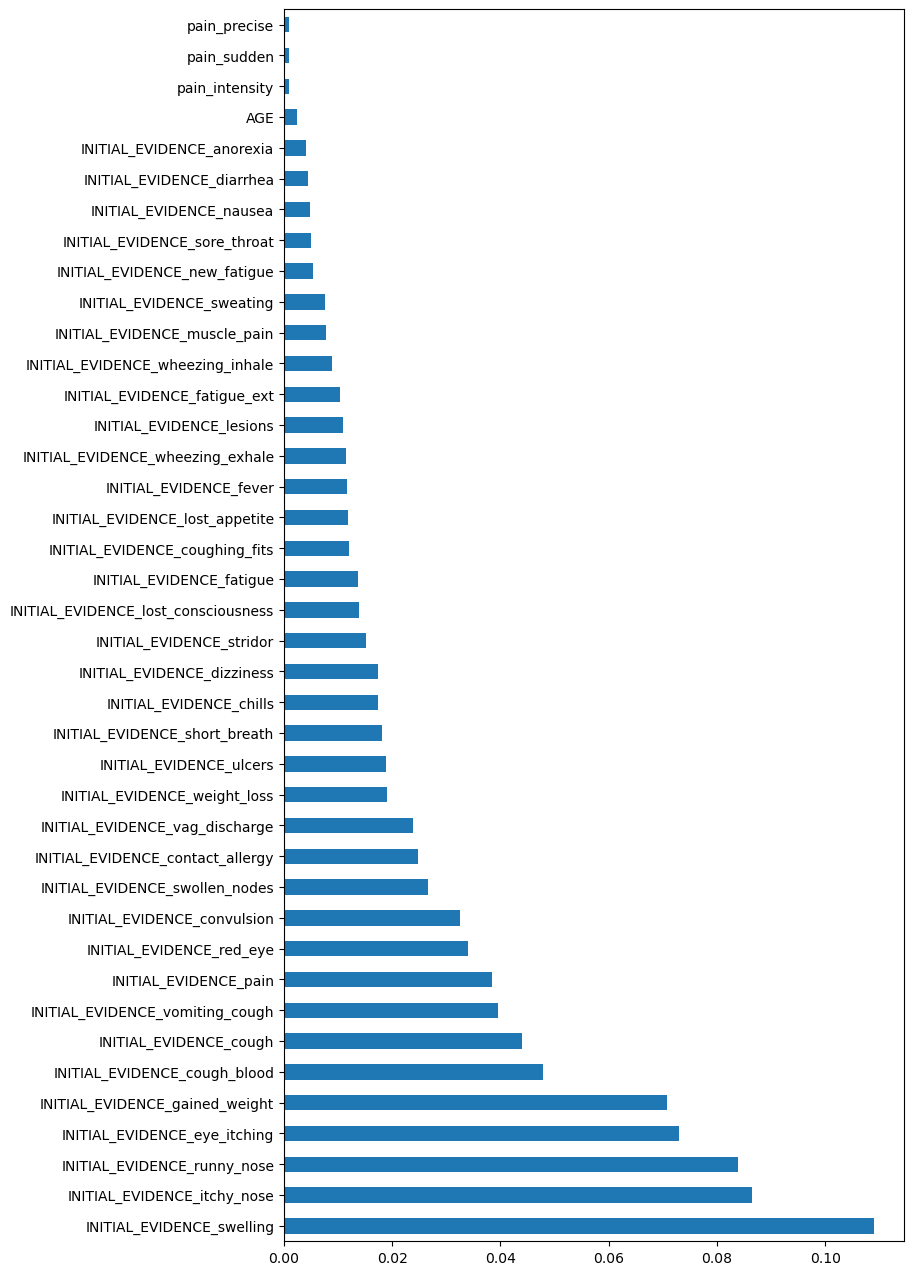

In [10]:
feat_importances = pd.Series(rf_prelim.feature_importances_, index=X_train.columns)
feat_importances.describe()
plt.figure(figsize=(8,16))
feat_importances.nlargest(40).plot(kind='barh')
plt.show()

In [11]:
initial_evidences = [c for c in X_train.columns.values if "INITIAL_EVIDENCE" in c]
initial_evidences.append("AGE")

In [12]:
def clean_data(X, y, feat_importances, quantile, val=False, trav_sex=True):

    low = feat_importances.loc[feat_importances.values < feat_importances.quantile(quantile)].index
    X_high = X.drop(columns=low)

    if val and trav_sex:
        return X_high.drop(columns='trav1_N'), y
    elif val:
        return X_high, y
    elif trav_sex:
        drop_rows = X_high.drop(columns=initial_evidences)
        drop_rows = drop_rows.drop(columns=['SEX_F', 'SEX_M', 'trav1_N'])
        clean_X = X_high.drop(index=drop_rows.index[np.all(drop_rows == 0, axis=1)],
                        columns='trav1_N')
    else:
        drop_rows = X_high.drop(columns=initial_evidences)
        clean_X = X_high.drop(index=drop_rows.index[np.all(drop_rows == 0, axis=1)])
    
    clean_y = y.drop(index=drop_rows.index[np.all(drop_rows == 0, axis=1)])

    return clean_X, clean_y

# Cross validation

In [13]:
quantile = 0.5

kfold = StratifiedKFold(n_splits=5,
                        shuffle=True,
                        random_state=740)

In [14]:
reports = []

for i, (train_index, test_index) in enumerate(kfold.split(X, y)):

    # data splitting
    X_tt = X.iloc[train_index]
    X_ho = X.iloc[test_index]

    y_tt = y[train_index]
    y_ho = y[test_index]

    # feature selection
    X_clean, y_clean = clean_data(X_tt, y_tt, 
                                  feat_importances, 
                                  quantile)
    
    X_clean_v, y_clean_v = clean_data(X_ho, y_ho,
                                      feat_importances,
                                      quantile,
                                      val=True)
    
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                bootstrap=bootstrap)
    
    rf.fit(X_clean, y_clean)
    pred = rf.predict(X_clean_v)
    reports.append(classification_report(y_clean_v, pred,
                                         output_dict=True))
    print(classification_report(y_clean_v, pred,
                                         output_dict=False, digits=3))
    


                         precision    recall  f1-score   support

     Allergic sinusitis      0.858     0.870     0.864      5668
            Anaphylaxis      0.978     0.394     0.561      6295
                 Chagas      1.000     0.235     0.380      2075
HIV (initial infection)      0.399     0.756     0.522      6573
              Influenza      0.883     0.184     0.304      6080
        Localized edema      0.524     1.000     0.688      6304
                    SLE      0.999     0.277     0.434      2689
            Sarcoidosis      0.578     0.709     0.637      4863
           Tuberculosis      0.565     0.457     0.505      3650
         Whooping cough      1.000     1.000     1.000      1323

               accuracy                          0.604     45520
              macro avg      0.778     0.588     0.590     45520
           weighted avg      0.731     0.604     0.577     45520

                         precision    recall  f1-score   support

     Allergic sinusit

In [15]:
reports

[{'Allergic sinusitis': {'precision': 0.8581375108790252,
   'recall': 0.8697953422724065,
   'f1-score': 0.8639271006746693,
   'support': 5668.0},
  'Anaphylaxis': {'precision': 0.9775236593059937,
   'recall': 0.3938046068308181,
   'f1-score': 0.5614313214811459,
   'support': 6295.0},
  'Chagas': {'precision': 1.0,
   'recall': 0.2346987951807229,
   'f1-score': 0.3801717408274785,
   'support': 2075.0},
  'HIV (initial infection)': {'precision': 0.3986529826812059,
   'recall': 0.7564278107409098,
   'f1-score': 0.5221317931215542,
   'support': 6573.0},
  'Influenza': {'precision': 0.8829113924050633,
   'recall': 0.18355263157894736,
   'f1-score': 0.30392156862745096,
   'support': 6080.0},
  'Localized edema': {'precision': 0.5243283706229727,
   'recall': 1.0,
   'f1-score': 0.6879467452392645,
   'support': 6304.0},
  'SLE': {'precision': 0.998661311914324,
   'recall': 0.2774265526217925,
   'f1-score': 0.4342258440046566,
   'support': 2689.0},
  'Sarcoidosis': {'precisio

In [16]:
macro_recall = [c['macro avg']['recall'] for c in reports]
macro_precision = [c['macro avg']['precision'] for c in reports]
macro_f1 = [c['macro avg']['f1-score'] for c in reports]

In [17]:
print('recall mean', np.mean(macro_recall))
macro_recall


recall mean 0.5914315979705265


[0.5882198996953084,
 0.5896485306229421,
 0.5962860121569703,
 0.5893670350024107,
 0.5936365123750014]

In [18]:
print('precision mean', np.mean(macro_precision))
macro_precision

precision mean 0.7796527007049764


[0.7782936191958048,
 0.7789062943463596,
 0.7830014077290662,
 0.7785089374516894,
 0.7795532448019622]

In [19]:
print('f1-score mean', np.mean(macro_f1))
macro_f1

f1-score mean 0.593728073953077


[0.5896006464852469,
 0.5923587451959575,
 0.5995707891166017,
 0.5908253935530834,
 0.5962847954144961]

In [20]:
print('{:.2f} percent increase in precision'.format((np.mean(macro_precision) - prelim_report['macro avg']['precision'])*100))
print('{:.2f} percent increase in recall'.format((np.mean(macro_recall) - prelim_report['macro avg']['recall'])*100))
print('{:.2f} percent decrease in f1-score'.format(np.abs((np.mean(macro_f1) - prelim_report['macro avg']['f1-score'])*100)))

1.31 percent increase in precision
0.19 percent increase in recall
0.02 percent decrease in f1-score


# Performance on test set

In [21]:
## removing lesion_peeling, pain_radiate columns

df_test = df['test']

df_test.drop(columns=['lesions_peeling', 'pain_radiate'], inplace=True)


## one hot encoding for all categorical features
categorical_features=df_test.select_dtypes(include='object').columns.tolist()

categorical_features.remove('PATHOLOGY')
categorical_features.remove('pain_somewhere')
categorical_features.remove('lesion_location')

df_test = pd.get_dummies(df_test,
                          columns=categorical_features,
                          dtype=int)


df_test['lesion_location'] = (df_test['lesion_location'] != 'nowhere').astype(int)
df_test['pain_somewhere'] = (df_test['pain_somewhere'] != 'nowhere').astype(int)

X_test = df_test.drop(columns=['PATHOLOGY', 'index'])
y_test = df_test.PATHOLOGY

In [22]:
X_clean, y_clean = clean_data(X, y, 
                                  feat_importances, 
                                  quantile)
    
X_clean_test, y_clean_test = clean_data(X_test, y_test,
                                    feat_importances,
                                    quantile,
                                    val=True)

rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            bootstrap=bootstrap)

rf.fit(X_clean, y_clean)
pred = rf.predict(X_clean_test)
print(classification_report(y_clean_v, pred,
                                        output_dict=False, digits=3))

KeyError: "['swelling_location_calf(L)', 'swelling_location_thigh(R)'] not found in axis"